In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from IPython.display import Image
from datetime import date

# World's Most Valuable Sports Teams

### By Daryl Adopo

In 2013, [Column five media](https://www.columnfivemedia.com/work/interactive-most-valuable-sports-franchises/) created an interactive visualization about Forbes' world's most valuable sports teams ranking. The world's most valuable sports teams, as ranked annually by the American magazine Forbes, include teams from soccer/football, American football, baseball, and basketball.
I was amazed by the quality of the visualization which conveyed all the information from Forbe's ranking without overwhelming the viewer.

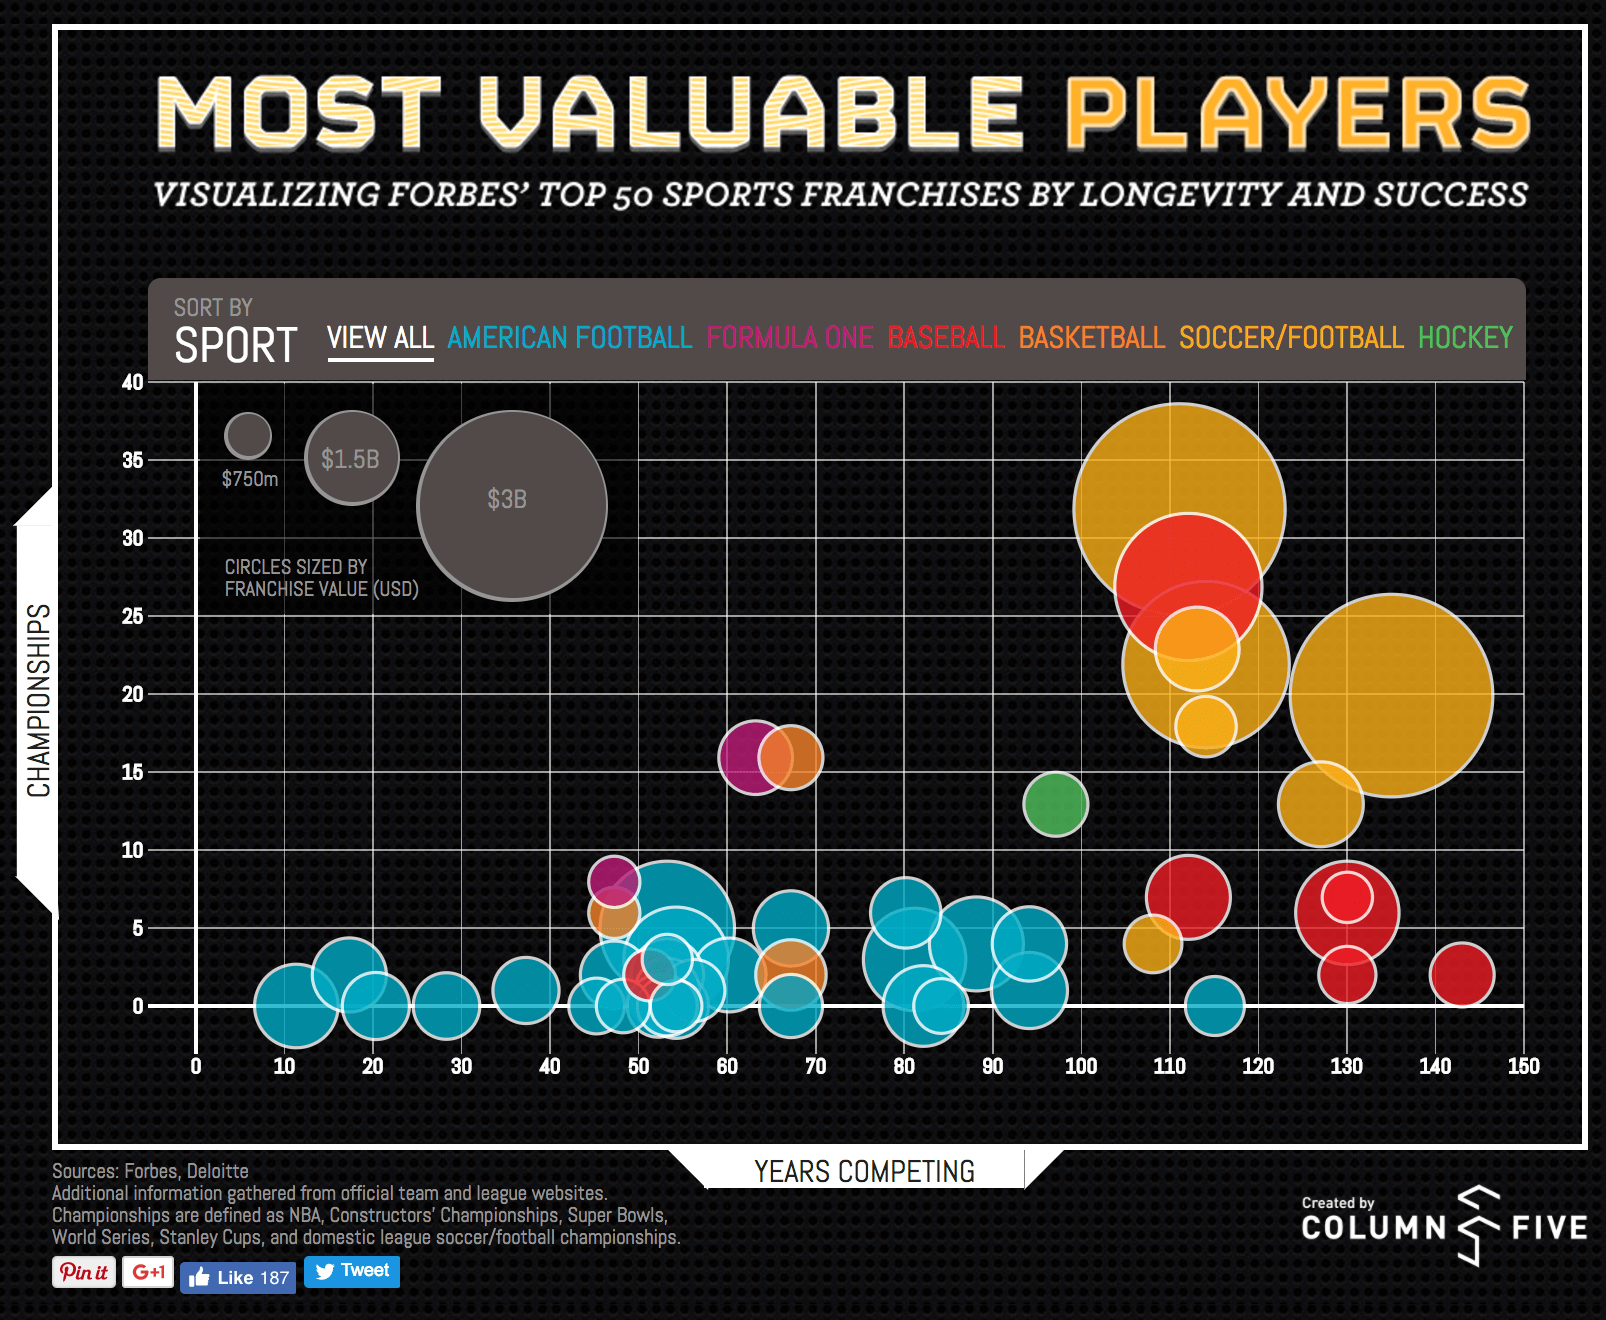

In [2]:
# Load image from local storage
Image(filename = "images/MostValuableSportFranchise.png", width = 600, height = 300)

The pandemic has caused a world of chaos for the sports industry, but billionaire owners are thriving, with the average value of the world’s top teams jumping **9.9%**, to **$3.4** billion.

I could not find an up-to-date version of the graph even though Forbes published the [2021 ranking](https://www.forbes.com/sites/mikeozanian/2021/05/07/worlds-most-valuable-sports-teams-2021/?sh=fc178153e9e4). 
So, I decided to create one myself.

The data comes directly from the Forbes article and it is not in a ready to be used format. 
This is a great opportunity to practice web scraping!
Let me take you to my learning journey.

## Web Scraping Forbes

In [3]:
article_url="https://www.forbes.com/sites/mikeozanian/2021/05/07/worlds-most-valuable-sports-teams-2021/"

# Make a GET request to fetch the raw HTML content
html_content = requests.get(article_url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")

# print(soup.prettify()) # Inspect the source code to find the relevant information

First, we need to get the list of the 50 teams and the relevant information about them (Team Value, Number of Championships Won, Number of years competed)

In [4]:
# Individual Links to the Top 50 Teams
links = soup.find_all("a", {'href': re.compile(r'https?://(www.)?forbes.com/teams/.*')})

teams_url = list()
for link in links[1:]:
    teams_url.append(link.attrs['href'])
    
teams_url[:5]

['https://www.forbes.com/teams/dallas-cowboys/',
 'https://www.forbes.com/teams/new-york-yankees/',
 'https://www.forbes.com/teams/new-york-knicks/',
 'https://www.forbes.com/teams/barcelona/',
 'https://www.forbes.com/teams/real-madrid/']

Each link directs us to a page with the main information about the team with a field (Team Value,...) and a value associated with it ($4.76B,...).

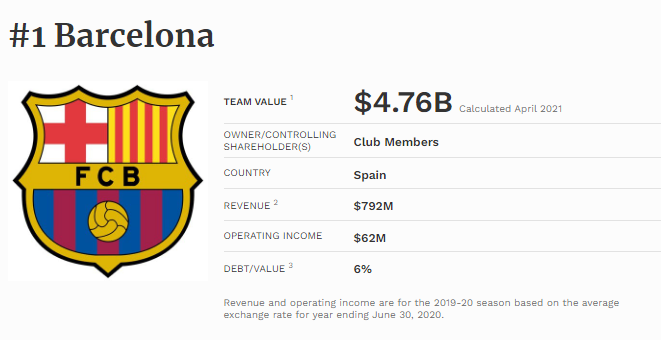

In [5]:
Image(filename = "images/Barcelona.png", width = 600, height = 300)

In [6]:
#Names of the teams 
headers = soup.find_all("h2", {'class':'subhead-embed color-accent bg-base font-accent font-size text-align'})

#Extracting the text from the HTML
team_names = list()
for header in headers[1:]:
    team_names.append(header.text)
    
team_names[:5]

['1. Dallas Cowboys (NFL) ',
 '2. New York Yankees (MLB) ',
 '3.\xa0New York Knicks (NBA)',
 '4.\xa0Barcelona (Soccer)',
 '5.\xa0Real Madrid (Soccer)']

In [7]:
# Split Rank, Team Name and Sport
rank = [i+1 for i in range(50)]
names = list()
sports = list()

for team_name in team_names:
    temp = team_name.split('.')
    temp2 = re.sub(r' \(.*\)', '', temp[1])
    
    names.append(temp2.replace(u'\xa0', '').strip())
    sports.append(re.search(r'\(.*\)', temp[1]).group(0)[1:-1])
    
print(names[:5])
print(sports[:5])

['Dallas Cowboys', 'New York Yankees', 'New York Knicks', 'Barcelona', 'Real Madrid']
['NFL', 'MLB', 'NBA', 'Soccer', 'Soccer']


Now, we can collect the data from each team's page and store it in a dataframe.

In [8]:
data=[]
for i, name, sport, url in zip(rank, names, sports, teams_url):
    row={"Rank": i, "Team":name, "Sport":sport}
    
    html_content = requests.get(url).text
    soup = BeautifulSoup(html_content, "lxml")
    
    #
    fields = soup.find_all("span", {'class':'profile-row__type-title'})
    values = soup.find_all("span", {'class':'profile-row__value-text'})
    
    for field, value in zip(fields, values):
        
        # Striping $ and B from Team Value and converting to float
        if field.text == "Team Value":
            row[field.text]= float(value.text[1:-1])
            continue
            
        row[field.text]= value.text
    
    # Adding link to the page
    row['url'] = url
    
    #Appending row of data
    data.append(row)    

In [9]:
# Row Sample
data[3]

{'Rank': 4,
 'Team': 'Barcelona',
 'Sport': 'Soccer',
 'Team Value': 4.76,
 'Owner/Controlling Shareholder(s)': 'club members',
 'Country': 'Spain',
 'Revenue': '$792M',
 'Operating Income': '$62M',
 'Debt/Value': '6%',
 'url': 'https://www.forbes.com/teams/barcelona/'}

In [10]:
# Creating Data Frame
df = pd.DataFrame.from_dict(data).set_index('Rank')

# Keeping Relevant Data
df = df[['Team', 'Sport','Team Value', 'Championships', 'Year Purchased']]

Though I was able to successfully scrape the websites, I noticed that there were still a good amount of missing data. Mainly coming from the 9 soccer teams.
In order to reproduce the visual, I will need to fill in those values.

In [11]:
Soccer_Teams = df[df['Sport'] == 'Soccer']
Soccer_Teams

,Team,Sport,Team Value,Championships,Year Purchased
Rank,,,,,
4,Barcelona,Soccer,4.76,NaN,NaN
5,Real Madrid,Soccer,4.75,NaN,NaN
10,Bayern Munich,Soccer,4.22,NaN,NaN
11,Manchester United,Soccer,4.20,NaN,NaN
12,Liverpool,Soccer,4.10,NaN,NaN
14,Manchester City,Soccer,4.00,NaN,NaN
27,Chelsea,Soccer,3.20,NaN,NaN
38,Arsenal,Soccer,2.80,NaN,NaN
45,Paris Saint-Germain,Soccer,2.50,NaN,NaN


In [12]:
# Export Data
df.to_csv("data/forbes_top_50.csv", index=True)

I filled the Championships field with the number of UEFA Champions League won and the year when the team was founded.

In [13]:
# Importing the clean dataset
forbes50 = pd.read_csv("data/forbes.csv").set_index("Rank")

forbes50[forbes50['Sport']=='Soccer']

,Team,Sport,Team Value,Championships,Year Purchased
Rank,,,,,
4,Barcelona,Soccer,4.76,5,1899
5,Real Madrid,Soccer,4.75,13,1902
10,Bayern Munich,Soccer,4.22,6,1900
11,Manchester United,Soccer,4.20,3,1902
12,Liverpool,Soccer,4.10,6,1892
14,Manchester City,Soccer,4.00,0,1894
27,Chelsea,Soccer,3.20,2,1905
38,Arsenal,Soccer,2.80,0,1886
45,Paris Saint-Germain,Soccer,2.50,0,1970


There are no more missing values.

In [14]:
# Adding the 'Year Competing' calculated field
forbes50['Year Competing'] = date.today().year - forbes50['Year Purchased']
forbes50.head()

,Team,Sport,Team Value,Championships,Year Purchased,Year Competing
Rank,,,,,,
1,Dallas Cowboys,NFL,6.50,5,1989,32
2,New York Yankees,MLB,5.25,27,1973,48
3,New York Knicks,NBA,5.80,2,1997,24
4,Barcelona,Soccer,4.76,5,1899,122
5,Real Madrid,Soccer,4.75,13,1902,119


In [15]:
# Making sure all the variables have the appropriate data type
forbes50.dtypes

Team               object
Sport              object
Team Value        float64
Championships       int64
Year Purchased      int64
Year Competing      int64
dtype: object

In [16]:
# The Data is Clean and Ready for visualization
forbes50.to_csv('data/forbes_top_50_clean.csv', index=True)

## Data Visualization

The following visualizations when genrated using [Tableau](https://www.tableau.com/).

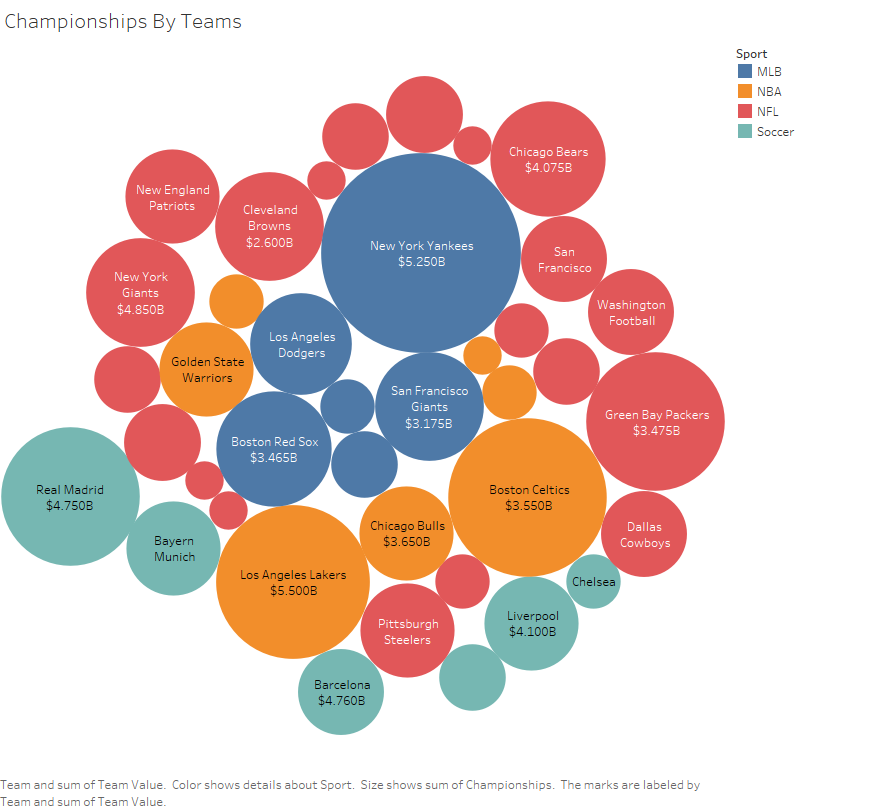

In [17]:
Image(filename = "Championships By Teams.png")

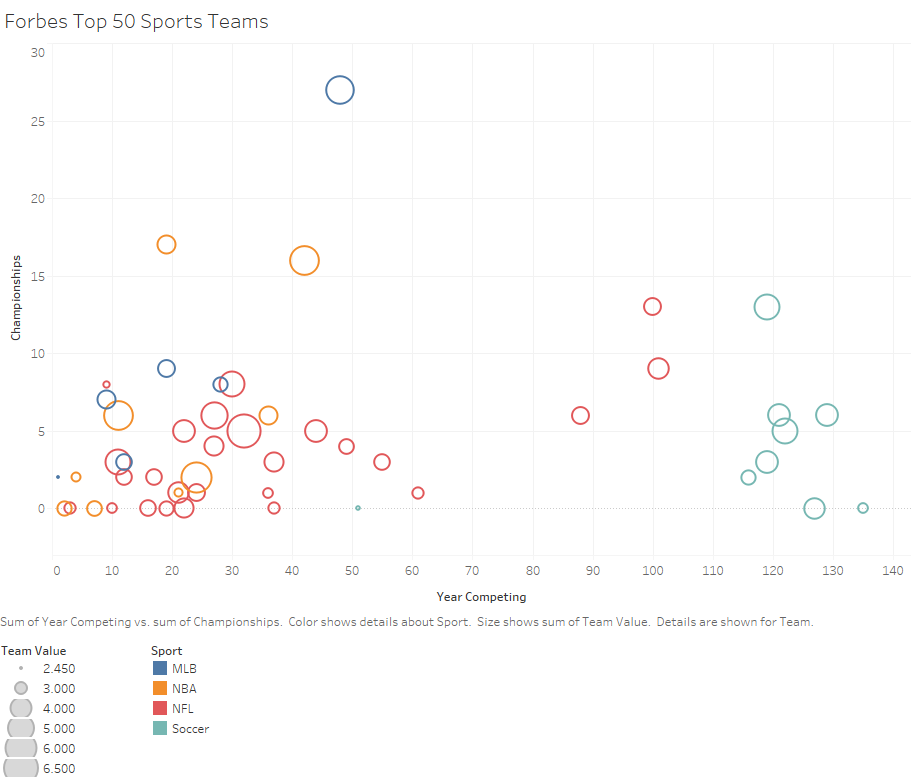

In [18]:
Image(filename = "Forbes Top 50 Sports Teams.png")

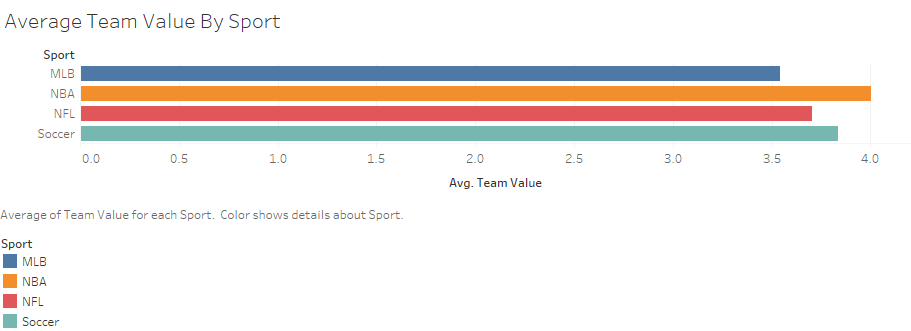

In [19]:
Image(filename = "Average Team Value By Sport.png")

Thank you for making it this far, I hope you enjoyed the ride and learned a lot!